<a href="https://www.kaggle.com/code/oscarm524/ps-s4-ep10-eda-submission-modeling?scriptVersionId=199122933" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Notebook Versions

- Version 1 (09/30/2024)
    * EDA 
    * Baseline modeling 1.0
    
    
- Version 2 (10/01/2024)
    * Baseline modeling 1.0 updated
    
    
# Loading Libraries

In [1]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import gc

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import kurtosis, skew, gmean, mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, r2_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge, RidgeCV
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVR

from category_encoders import TargetEncoder

import xgboost as xgb

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

from sklearn.neural_network import MLPClassifier

import optuna

# Reading Data Files

In [2]:
%%time
train = pd.read_csv('../input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('../input/playground-series-s4e10/test.csv', index_col=0)

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (58645, 12)
The dimension of the test dataset is: (39098, 11)
CPU times: user 137 ms, sys: 45.3 ms, total: 182 ms
Wall time: 247 ms


In [3]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [4]:
test.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


First, let's check for missing values in the `train` and `test` data frames.

In [5]:
print('--- Train ---\n')
print(100*train.isnull().sum() / train.shape[0])
print('\n')
print('--- Test ---\n')
print(100*test.isnull().sum() / train.shape[0])

--- Train ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
loan_status                   0.0
dtype: float64


--- Test ---

person_age                    0.0
person_income                 0.0
person_home_ownership         0.0
person_emp_length             0.0
loan_intent                   0.0
loan_grade                    0.0
loan_amnt                     0.0
loan_int_rate                 0.0
loan_percent_income           0.0
cb_person_default_on_file     0.0
cb_person_cred_hist_length    0.0
dtype: float64


There are no missing values neither in the `train` nor `test` data frames. Next, we check for potential duplicates.

In [6]:
print(f"There are {sum(train.duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"After dropping the loan_status column, there are {sum(train.drop(columns=['loan_status']).duplicated())} duplicated rows in the train data frame.")

print("\n")
print(f"There are {sum(test.duplicated())} duplicated rows in the test data frame.")

There are 0 duplicated rows in the train data frame.


After dropping the loan_status column, there are 0 duplicated rows in the train data frame.


There are 0 duplicated rows in the test data frame.


Finally, we check if there are any observations that appear in both the `train` and `test` data frames.

In [7]:
temp_train = train.drop(columns=['loan_status'], axis=1)
temp_test = test

inner_join = pd.merge(temp_train, temp_test)
print(f"There are {inner_join.shape[0]} observations that appear in both the train and test data frames")

There are 0 observations that appear in both the train and test data frames


# Data Exploration

First, we start by exploring the distribution of `loan_status`.

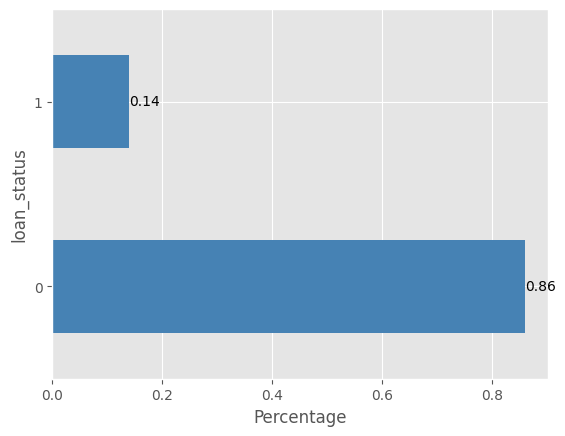

In [8]:
ax = round(train['loan_status'].value_counts(normalize=True), 2).plot(kind='barh', color='steelblue')
ax.bar_label(ax.containers[0], label_type='edge')
ax.margins(y=0.1)
plt.xlabel('Percentage');

From the above chart, we see that this is an imbalanced dataset. `loan_status=1` is the less frequent label. Next, we explore the relationships between the input features and `loan_status`.

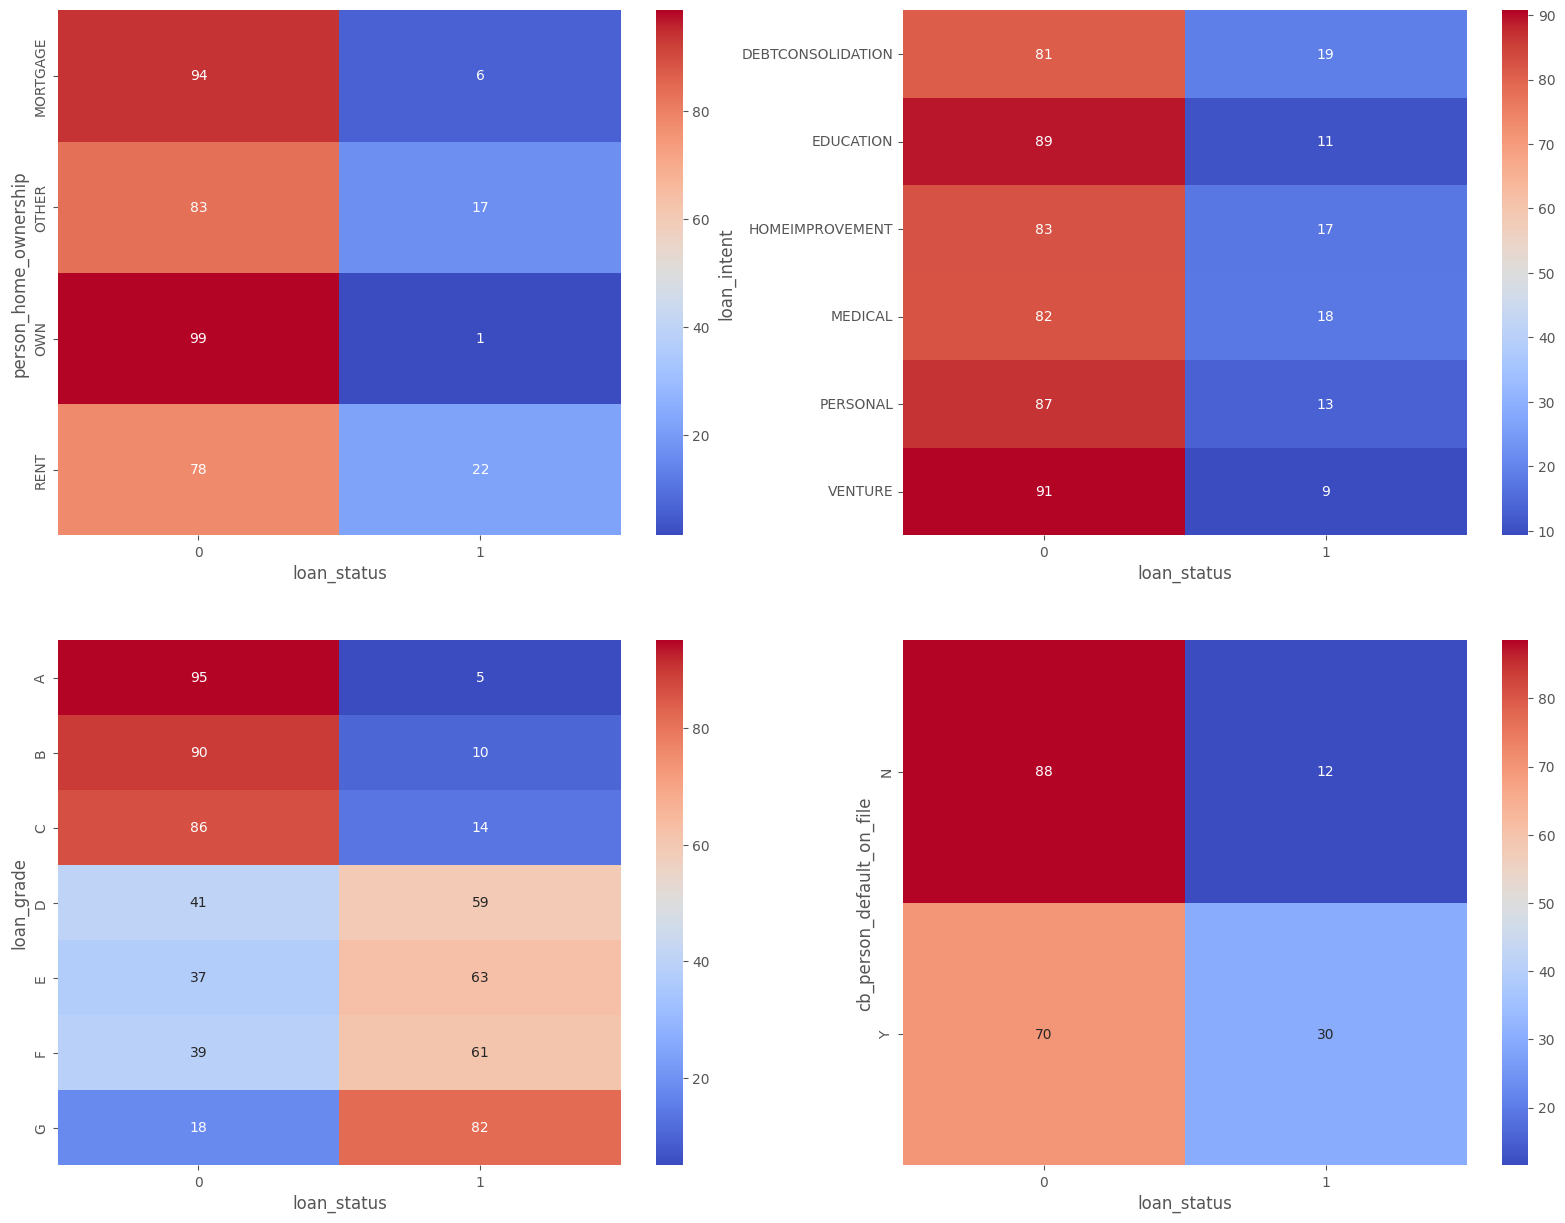

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(data=round(100*pd.crosstab(train['person_home_ownership'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 0])
sns.heatmap(data=round(100*pd.crosstab(train['loan_intent'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[0, 1])
sns.heatmap(data=round(100*pd.crosstab(train['loan_grade'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 0]);
sns.heatmap(data=round(100*pd.crosstab(train['cb_person_default_on_file'], train['loan_status'], normalize=0), 2), annot=True, cmap=cmap, fmt='.0f', ax=axes[1, 1]);

These are a couple of observations from the above charts:

- When `loan_grade` is equal to `D, E, F,` and `G` have the higher proportions of `loan_status=1`
- `cb_person_default_on_file=Y` have a higher proportion `loan_status=1` when compared to `cb_person_default_on_file=N`

Next, let's explore the distribution of the numerical features and potential relationships with `loan_status`.

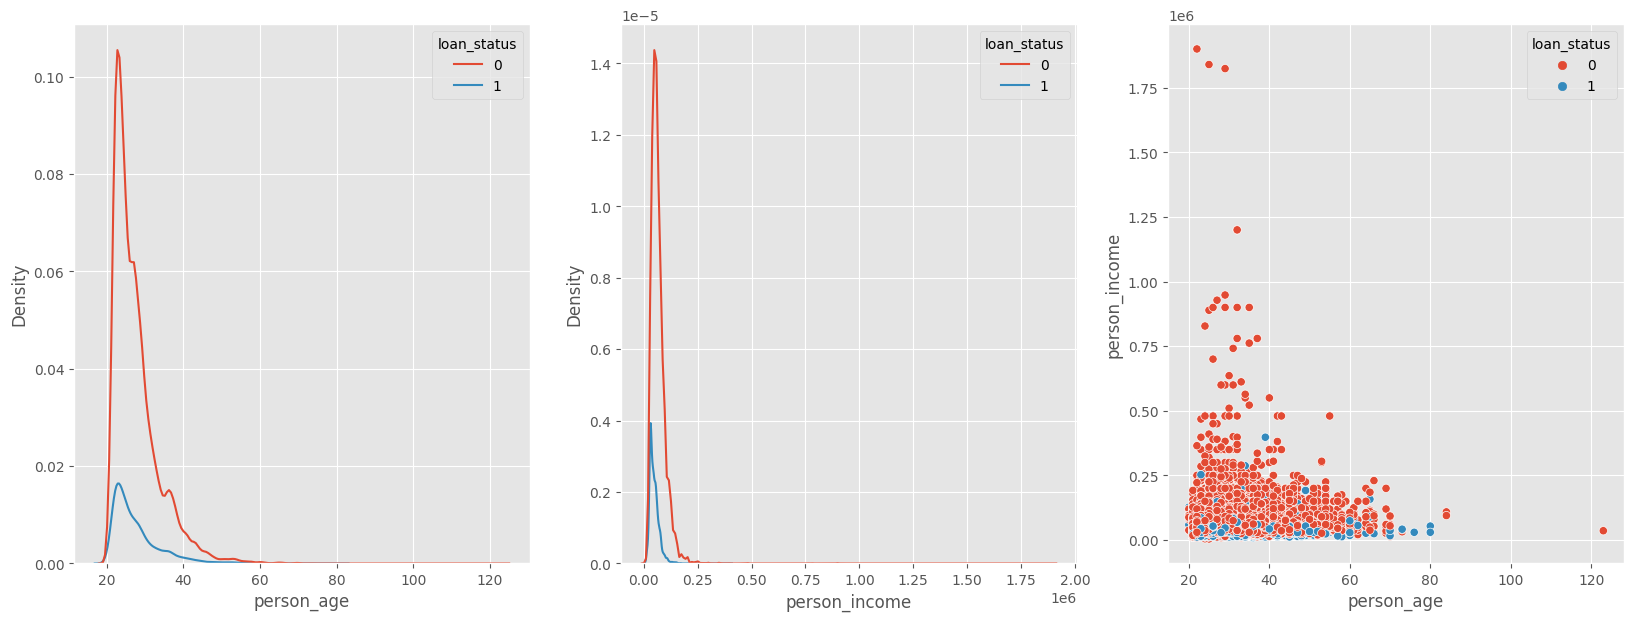

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_age', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='person_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_age', y='person_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_age` and `person_income`.
- There is one person with `person_age=123`.

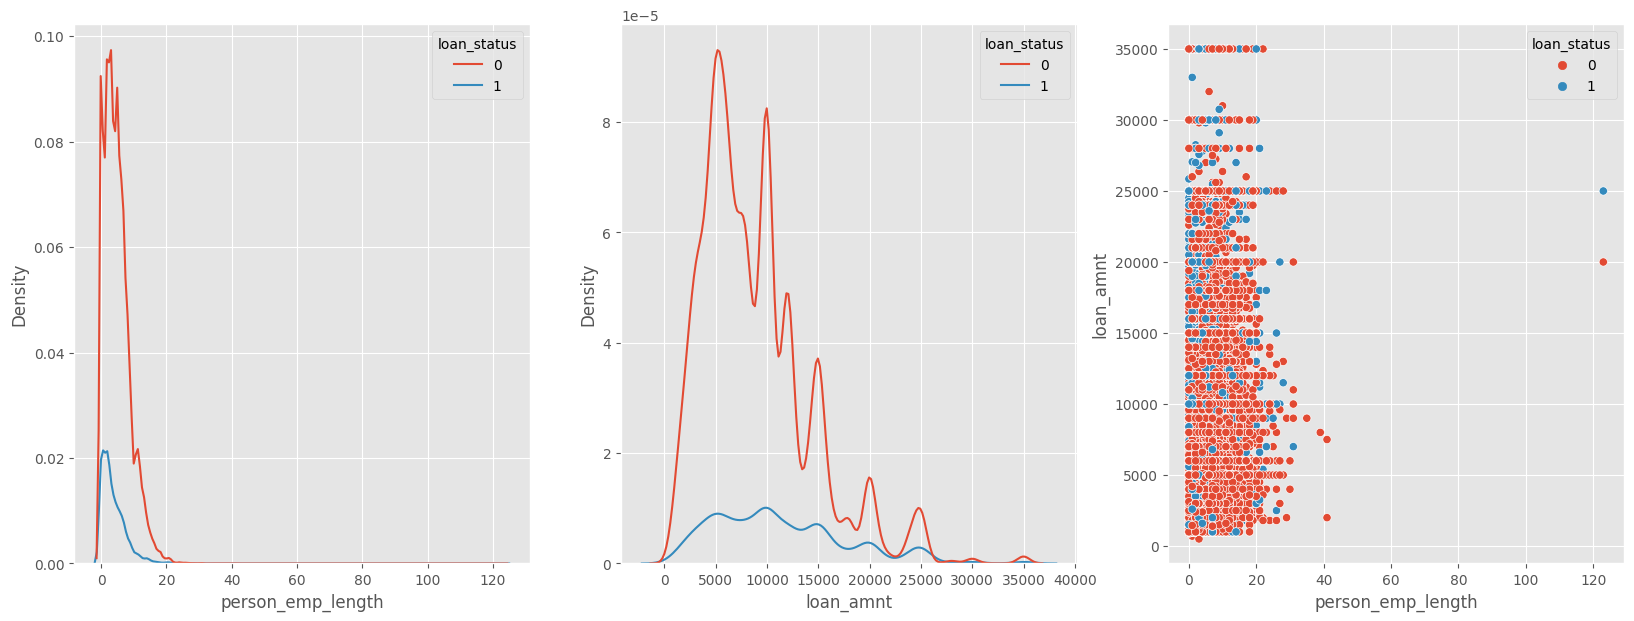

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='person_emp_length', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_amnt', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='person_emp_length', y='loan_amnt', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `person_emp_length` and `loan_amnt`.
- There are two persons with `person_emp_length=123`.

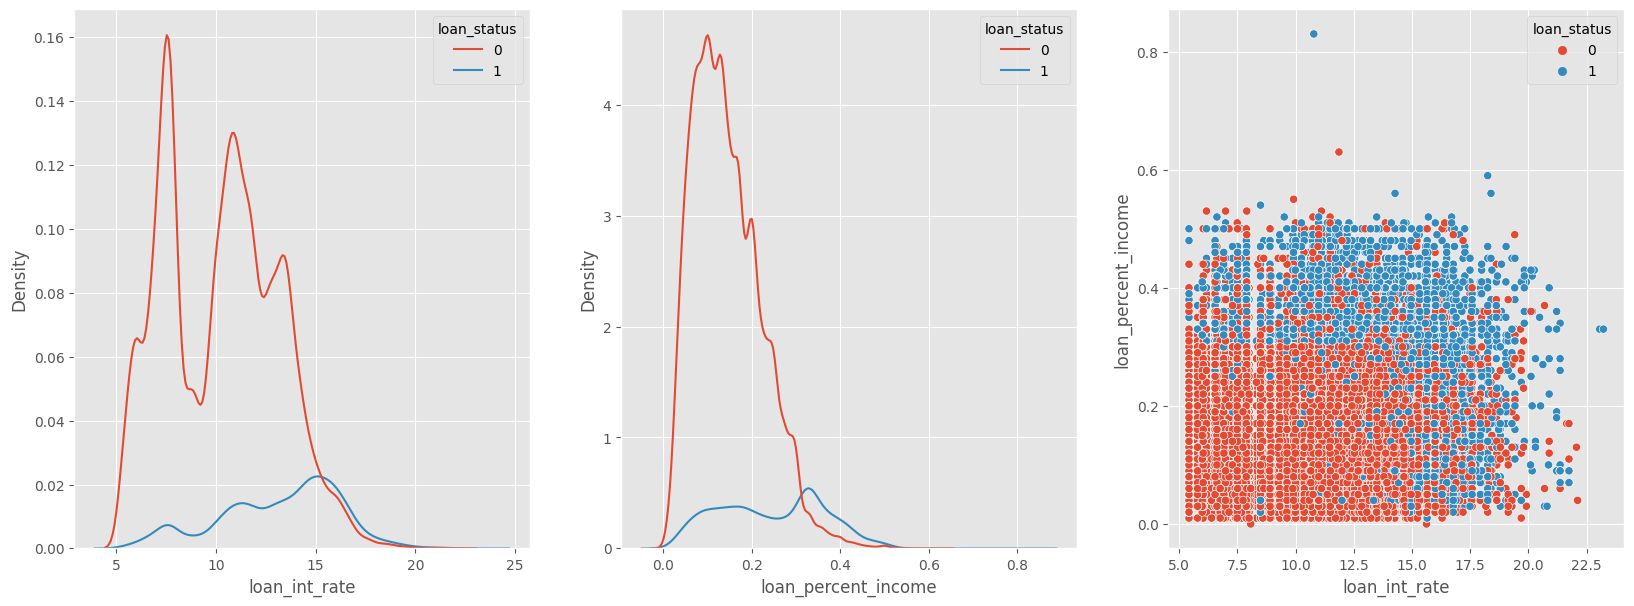

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sns.kdeplot(data=train, x='loan_int_rate', hue='loan_status', ax=axes[0]);
sns.kdeplot(data=train, x='loan_percent_income', hue='loan_status', ax=axes[1]);
sns.scatterplot(data=train, x='loan_int_rate', y='loan_percent_income', hue='loan_status', ax=axes[2]);

From the above charts, these are a couple of observations:

- `loan_status=0` and `loan_status=1` have similar distributions for `loan_int_rate` and `loan_percent_income`.
- There are two loans with `loan_int_rate>23`.
- There are two loans with `loan_percent_income>0.6`.

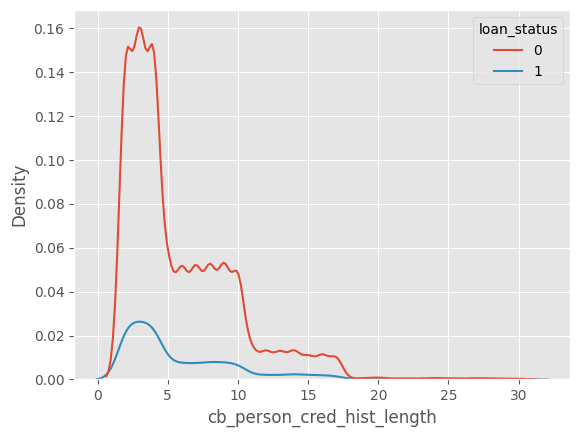

In [13]:
sns.kdeplot(data=train, x='cb_person_cred_hist_length', hue='loan_status');

From the above chart, we see that the distribution of `cb_person_cred_hist_length` is similar whether `loan_statu` is 0 or 1.

# Baseline Modeling 1.0

We first preprocess the data as follows.

In [14]:
%%time
cat_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

def converting_datatypes(df, cat_cols, df_train=False):
    
    for col in cat_cols:
        df[col] = df[col].astype('category')
    
    df['person_age'] = df['person_age'].astype('int32')
    df['cb_person_cred_hist_length'] = df['cb_person_cred_hist_length'].astype('int32') 
    
    if df_train==True:

        df['loan_status'] = df['loan_status'].astype('int8')
        
    return df
        
train = converting_datatypes(train, cat_cols ,df_train=True)
test = converting_datatypes(test, cat_cols)


def clip_data(df):
    
    df['person_age'] = df['person_age'].clip(None, 90)
    df['person_emp_length'] = df['person_emp_length'].clip(None, 60) 
    
    return df

train = clip_data(train)
test = clip_data(test)

CPU times: user 42.4 ms, sys: 0 ns, total: 42.4 ms
Wall time: 41.5 ms


Then, we define the input and target feature for modeling purposes.

In [15]:
%%time
X = train.drop(columns=['loan_status'], axis=1)
Y = train['loan_status']

skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)

CPU times: user 2.98 ms, sys: 1.12 ms, total: 4.1 ms
Wall time: 4.8 ms


First, we train the `RandomForestClassifier` model as follows.

In [16]:
# Converting label to dummies
train_dummies = pd.get_dummies(X[cat_cols], drop_first=True, dtype='int8')
RF_train = pd.concat([X.drop(columns=cat_cols, axis=1), train_dummies], axis=1)

test_dummies = pd.get_dummies(test[cat_cols], drop_first=True, dtype='int8')
RF_test = pd.concat([test.drop(columns=cat_cols, axis=1), test_dummies], axis=1)

rf_params = {'n_estimators': 148,
             'max_depth': 15,
             'min_samples_split': 17,
             'min_samples_leaf': 6,
             'n_jobs': -1}

scores, rf_oof_preds, rf_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(RF_train, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = RF_train.iloc[train_index], RF_train.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    rf_md = RandomForestClassifier(**rf_params).fit(X_train, y_train)
    preds = rf_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['rf_preds'] = preds
    oof_preds['fold'] = i
    rf_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['rf_preds'] = rf_md.predict_proba(RF_test)[:, 1]
    test_preds['fold'] = i
    rf_test_preds.append(test_preds)

rf_oof_score = np.mean(scores)
rf_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the RandomForest model is {rf_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the RandomForest model is {rf_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9357862406399923
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.944393757217176
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9400145236366234
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9373674122927107
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9346360162379018
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9386916364129962
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9400421269213413
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.935439123740985
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9329598508292622
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9330615365014652
The 10-fold average oof ROC-AUC score of the RandomForest model is 0.9372392224430455
The 10-fold std oof ROC-AUC score of

Next, we train the `LightGBM` model as follows.

In [17]:
%%time
lgb_params = {'learning_rate': 0.09030331403653566,
              'n_estimators': 190,
              'max_depth': 15,
              'reg_alpha': 0.25370376964322267,
              'reg_lambda': 0.06912978243728862,
              'num_leaves': 38,
              'colsample_bytree': 0.4816656035216278,
              'verbose': -1,
              'n_jobs': -1}

scores, lgb_oof_preds, lgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
    
    lgb_md = LGBMClassifier(**lgb_params).fit(X_train, y_train)
    preds = lgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['lgb_preds'] = preds
    oof_preds['fold'] = i
    lgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['lgb_preds'] = lgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    lgb_test_preds.append(test_preds)

lgb_oof_score = np.mean(scores)
lgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the LGBM model is {lgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the LGBM model is {lgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9615514101022608
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9621418792633423
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9604949941072128
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9578878822871156
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9598626206830871
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9618800180509929
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9586113118761483
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9603635441386068
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9543917136893444
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9596434095420214
The 10-fold average oof ROC-AUC score of the LGBM model is 0.9596828783740132
The 10-fold std oof ROC-AUC score of the L

After that, we train the `XGBoost` model as follows.

In [18]:
%%time
xgb_params = {'n_estimators': 199,
              'max_depth': 12,
              'learning_rate': 0.09304789779291263,
              'gamma': 0.2571967403496238,
              'min_child_weight': 20,
              'colsample_bytree': 0.5141737333809174,
              'n_jobs': -1,
              'enable_categorical': True}

scores, xgb_oof_preds, xgb_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y.iloc[test_index]
                        
    xgb_md = XGBClassifier(**xgb_params).fit(X_train, y_train)
    preds = xgb_md.predict_proba(X_test)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['xgb_preds'] = preds
    oof_preds['fold'] = i
    xgb_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof ROC-AUC score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['xgb_preds'] = xgb_md.predict_proba(test)[:, 1]
    test_preds['fold'] = i
    xgb_test_preds.append(test_preds)

xgb_oof_score = np.mean(scores)
xgb_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the XGBoost model is {xgb_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the XGBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof ROC-AUC score is 0.9584907322531875
------------ Working on Fold 1 ------------
The oof ROC-AUC score is 0.9599021440220951
------------ Working on Fold 2 ------------
The oof ROC-AUC score is 0.9557338603111868
------------ Working on Fold 3 ------------
The oof ROC-AUC score is 0.9544329234175783
------------ Working on Fold 4 ------------
The oof ROC-AUC score is 0.9564890894156022
------------ Working on Fold 5 ------------
The oof ROC-AUC score is 0.9584948615395973
------------ Working on Fold 6 ------------
The oof ROC-AUC score is 0.9561903832025748
------------ Working on Fold 7 ------------
The oof ROC-AUC score is 0.9570726909672401
------------ Working on Fold 8 ------------
The oof ROC-AUC score is 0.9558919940988971
------------ Working on Fold 9 ------------
The oof ROC-AUC score is 0.9572874930195285
The 10-fold average oof ROC-AUC score of the XGBoost model is 0.9569986172247488
The 10-fold std oof ROC-AUC score of th

Next, we train the `CatBoost` model as follows.

In [19]:
cb_params = {'loss_function': 'Logloss',
             'iterations': 195,
             'learning_rate': 0.09381481508561976,
             'depth': 11,
             'bagging_temperature': 0.0850640366226123,
             'l2_leaf_reg': 0,
             'grow_policy': 'Lossguide',
             'task_type': 'CPU'}

test_pool = Pool(data=test, cat_features=cat_cols)

scores, cat_oof_preds, cat_test_preds = list(), list(), list()
for i, (train_index, test_index) in enumerate(skf.split(X, Y)):
    
    print(f"------------ Working on Fold {i} ------------")
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model_pool = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_pool = Pool(data=X_test, label=y_test, cat_features=cat_cols)
            
    cat_md = CatBoostClassifier(**cb_params).fit(model_pool, eval_set=eval_pool, verbose=0)
    preds = cat_md.predict_proba(eval_pool)[:, 1]
    
    oof_preds = pd.DataFrame()
    oof_preds['y'] = y_test.values
    oof_preds['cat_preds'] = preds
    oof_preds['fold'] = i
    cat_oof_preds.append(oof_preds)
    
    score = roc_auc_score(y_test, preds)
    print(f"The oof RMSE score is {score}")
    scores.append(score)
    
    test_preds = pd.DataFrame()
    test_preds['cat_preds'] = cat_md.predict_proba(test_pool)[:, 1]
    test_preds['fold'] = i
    cat_test_preds.append(test_preds)

cat_oof_score = np.mean(scores)  
cat_std = np.std(scores)
print(f"The 10-fold average oof ROC-AUC score of the CatBoost model is {cat_oof_score}")
print(f"The 10-fold std oof ROC-AUC score of the CatBoost model is {xgb_std}")

------------ Working on Fold 0 ------------
The oof RMSE score is 0.9571600338091213
------------ Working on Fold 1 ------------
The oof RMSE score is 0.9583169247985143
------------ Working on Fold 2 ------------
The oof RMSE score is 0.9621294984583517
------------ Working on Fold 3 ------------
The oof RMSE score is 0.9557538600730943
------------ Working on Fold 4 ------------
The oof RMSE score is 0.9523503291627481
------------ Working on Fold 5 ------------
The oof RMSE score is 0.9593474018358192
------------ Working on Fold 6 ------------
The oof RMSE score is 0.9563201693649885
------------ Working on Fold 7 ------------
The oof RMSE score is 0.9564428113349757
------------ Working on Fold 8 ------------
The oof RMSE score is 0.9550111151727168
------------ Working on Fold 9 ------------
The oof RMSE score is 0.9550008751635721
The 10-fold average oof ROC-AUC score of the CatBoost model is 0.9567833019173901
The 10-fold std oof ROC-AUC score of the CatBoost model is 0.0015265

Finally, we run an Optuna experiment to blend the out-of-fold predictions of `RandomForest`, `LightGBM`, `XGBoost`, and `CatBoost`.

In [20]:
%%time
oof_preds = pd.concat(lgb_oof_preds)
oof_preds['xgb_preds'] = pd.concat(xgb_oof_preds)['xgb_preds']
oof_preds['cat_preds'] = pd.concat(cat_oof_preds)['cat_preds']
oof_preds['rf_preds'] = pd.concat(rf_oof_preds)['rf_preds']


def objective(trial):
    
    weights = [trial.suggest_float(f"weight{n}", 1e-5, 1) for n in range(4)]

    scores = list()
    for i in range(0, 10):
        
        x_test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
        ens_pred = (weights[0]*x_test['lgb_preds'].values +
                    weights[1]*x_test['xgb_preds'].values + 
                    weights[2]*x_test['cat_preds'].values + 
                    weights[3]*x_test['rf_preds'].values) 
        
        y_test = x_test['y']
        score = roc_auc_score(y_test, ens_pred)
        scores.append(score)
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3000, n_jobs=-1)

[I 2024-10-02 01:21:40,510] A new study created in memory with name: no-name-a54ddbbc-77e8-4da6-a9ff-4c4de7ebcfb5
[I 2024-10-02 01:21:40,700] Trial 0 finished with value: 0.9584018855232926 and parameters: {'weight0': 0.6574573873271637, 'weight1': 0.7213312731508221, 'weight2': 0.6762519410056153, 'weight3': 0.4856744401034926}. Best is trial 0 with value: 0.9584018855232926.
[I 2024-10-02 01:21:40,723] Trial 1 finished with value: 0.9595986336024194 and parameters: {'weight0': 0.41374335665045336, 'weight1': 0.48811961734649195, 'weight2': 0.7376603624164738, 'weight3': 0.09994812098478931}. Best is trial 1 with value: 0.9595986336024194.
[I 2024-10-02 01:21:40,732] Trial 2 finished with value: 0.9573373371552885 and parameters: {'weight0': 0.8467564510178305, 'weight1': 0.798396545255754, 'weight2': 0.7830678042019273, 'weight3': 0.9485576836510606}. Best is trial 1 with value: 0.9595986336024194.
[I 2024-10-02 01:21:40,747] Trial 3 finished with value: 0.9577577700152794 and parame

CPU times: user 6min 4s, sys: 2.37 s, total: 6min 7s
Wall time: 6min 5s


In [21]:
%%time
print("Best Trial:")
best_trial = study.best_trial

print(f"  Value: {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

Best Trial:
  Value: 0.9604005970310237
  Params: 
    weight0: 0.9844812791376767
    weight1: 0.3288965120038331
    weight2: 0.4476355839270011
    weight3: 0.00014646773266516777
CPU times: user 388 µs, sys: 0 ns, total: 388 µs
Wall time: 374 µs


In [22]:
%%time
w = study.best_trial.params
scores = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']
    
    test = oof_preds[oof_preds['fold']==i].reset_index(drop=True)
    x_test = test.drop(columns=['fold', 'y'], axis=1)
    y_test = test['y']

    optuna_pred = (w['weight0']*test['lgb_preds'] + w['weight1']*test['xgb_preds'] + w['weight2']*test['cat_preds'] + w['weight3']*test['rf_preds'])
    score = roc_auc_score(y_test, optuna_pred)
    scores.append(score)

print(f"The 10-fold oof average ROC-AUC score of the Optuna Blender is {np.mean(scores)}")


The 10-fold oof average ROC-AUC score of the Optuna Blender is 0.9604005970310237
CPU times: user 112 ms, sys: 992 µs, total: 113 ms
Wall time: 112 ms


In [23]:
%%time
test_preds = pd.concat(lgb_test_preds)
test_preds['xgb_preds'] = pd.concat(xgb_test_preds)['xgb_preds']
test_preds['cat_preds'] = pd.concat(cat_test_preds)['cat_preds']
test_preds['rf_preds'] = pd.concat(rf_test_preds)['rf_preds']
test_preds.head()

CPU times: user 21.3 ms, sys: 13.9 ms, total: 35.2 ms
Wall time: 34.5 ms


,lgb_preds,fold,xgb_preds,cat_preds,rf_preds
0,0.987975,0,0.987820,0.990004,0.850206
1,0.012344,0,0.016124,0.016007,0.020043
2,0.534855,0,0.765667,0.626705,0.613227
3,0.010490,0,0.012575,0.013469,0.031043
4,0.053700,0,0.052235,0.048456,0.309949


In [24]:
%%time
test_pred_final = list()
for i in range(0, 10):
    
    x_train = oof_preds[oof_preds['fold']!=i].reset_index(drop=True)
    x = x_train.drop(columns=['fold', 'y'], axis=1)
    y = x_train['y']

    temp = test_preds[test_preds['fold']==i].reset_index(drop=True)
    optuna_pred = (w['weight0']*temp['lgb_preds'] + w['weight1']*temp['xgb_preds'] + w['weight2']*temp['cat_preds'] + w['weight3']*temp['rf_preds'])
    
    test_pred_final.append(optuna_pred)

CPU times: user 97 ms, sys: 940 µs, total: 97.9 ms
Wall time: 98.2 ms


In [25]:
%%time
submission = pd.read_csv('../input/playground-series-s4e10/sample_submission.csv')
submission['loan_status'] = np.mean(test_pred_final, axis=0)
submission.head()

CPU times: user 9.01 ms, sys: 5.97 ms, total: 15 ms
Wall time: 29.9 ms


,id,loan_status
0,58645,1.741135
1,58646,0.028230
2,58647,1.086542
3,58648,0.019772
4,58649,0.094605


In [26]:
%time
submission.to_csv('baseline_sub_1.csv', index=False)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs
